In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
RESULTS_DIR = Path('results')
COLUMN_SELECTIONS_DIR = Path('column_selections')
METHODS = ['HarderLASSO_QUT', 'LASSO_QUT', 'RandomForest', 'XGBoost', 'LassoNet']
S_VALUES = np.arange(0, 21, 2)

In [2]:
def parse_features(feature_string):
    """Parse comma-separated feature string into list of integers."""
    if pd.isna(feature_string) or feature_string == '':
        return []
    return [int(float(x.strip())) for x in str(feature_string).split(',')]

def load_simulation_data():
    """Load all simulation results and column selections."""
    all_results = []
    all_true_features = []

    for s in S_VALUES:
        results_file = RESULTS_DIR / f's_{s}_results.csv'
        if results_file.exists():
            df_results = pd.read_csv(results_file)
            df_results['s_value'] = s
            all_results.append(df_results)

        # Load true features
        true_features_file = COLUMN_SELECTIONS_DIR / f's_{s}.csv'
        if true_features_file.exists():
            df_true = pd.read_csv(true_features_file)
            df_true['s_value'] = s

            # Parse selected columns
            df_true['true_features'] = df_true['selected_columns'].apply(parse_features)
            df_true.drop(columns=['selected_columns'], inplace=True, errors='ignore')
            all_true_features.append(df_true)


    # Combine all data
    results_df = pd.concat(all_results, ignore_index=True)
    true_features_df = pd.concat(all_true_features, ignore_index=True)

    return results_df, true_features_df

# Load data
print("Loading simulation data...")
results_df, true_features_df = load_simulation_data()
print(f"Loaded {len(results_df)} result rows and {len(true_features_df)} true feature rows")

Loading simulation data...
Loaded 2200 result rows and 2200 true feature rows


In [3]:
# Parse selected features for each method
print("Parsing selected features...")
for method in METHODS:
    feature_col = f'{method}_features'
    if feature_col in results_df.columns:
        results_df[f'{method}_features'] = results_df[feature_col].apply(parse_features)
        print(f"✓ {method}")

Parsing selected features...
✓ HarderLASSO_QUT
✓ LASSO_QUT
✓ RandomForest
✓ XGBoost
✓ LassoNet


In [4]:
def calculate_pesr(selected_features, true_features):
    """Calculate Perfect Exact Support Recovery."""
    return set(selected_features) == set(true_features)

def calculate_fdr(selected_features, true_features):
    """Calculate False Discovery Rate."""
    if len(selected_features) == 0:
        return 0.0

    true_set = set(true_features)
    selected_set = set(selected_features)
    false_positives = selected_set - true_set

    return len(false_positives) / len(selected_features)

def calculate_tpr(selected_features, true_features):
    """Calculate True Positive Rate (Recall)."""
    if len(true_features) == 0:
        return 1.0 if len(selected_features) == 0 else 0.0

    true_set = set(true_features)
    selected_set = set(selected_features)
    true_positives = true_set & selected_set

    return len(true_positives) / len(true_features)

def calculate_f1(selected_features, true_features):
    """Calculate F1 Score."""
    precision = calculate_tpr(selected_features, true_features)
    recall = calculate_tpr(selected_features, true_features)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def calculate_metrics_for_method(results_df, true_features_df, method):
    """Calculate all metrics for a given method."""
    metrics = []

    for s in S_VALUES:
        s_results = results_df[results_df['s_value'] == s].copy()
        s_true = true_features_df[true_features_df['s_value'] == s].copy()

        if len(s_results) == 0 or len(s_true) == 0:
            continue

        merged = s_results.merge(s_true, on='simulation', suffixes=('', '_true'))

        # Calculate metrics for each simulation
        sim_metrics = []
        for _, row in merged.iterrows():
            selected = row[f'{method}_features']
            true = row['true_features']
            mse = row[f'{method}_mse']

            sim_metrics.append({
                'simulation': row['simulation'],
                's_value': s,
                'method': method,
                'pesr': calculate_pesr(selected, true),
                'fdr': calculate_fdr(selected, true),
                'tpr': calculate_tpr(selected, true),
                'f1': calculate_f1(selected, true),
                'mse': mse,
                'n_selected': len(selected),
                'n_true': len(true)
            })

        metrics.extend(sim_metrics)

    return pd.DataFrame(metrics)

# Calculate metrics for all methods
print("Calculating metrics for all methods...")
all_metrics = []

for method in METHODS:
    print(f"Processing {method}...", end=' ')
    method_metrics = calculate_metrics_for_method(results_df, true_features_df, method)
    all_metrics.append(method_metrics)
    print(f"✓ ({len(method_metrics)} records)")

# Combine all metrics
metrics_df = pd.concat(all_metrics, ignore_index=True)
print(f"\nTotal metrics calculated: {len(metrics_df)} records")

Calculating metrics for all methods...
Processing HarderLASSO_QUT... ✓ (2200 records)
Processing LASSO_QUT... ✓ (2200 records)
Processing RandomForest... ✓ (2200 records)
Processing XGBoost... ✓ (2200 records)
Processing LassoNet... ✓ (2200 records)

Total metrics calculated: 11000 records


In [5]:
# Calculate summary statistics
print("Calculating summary statistics...")
summary_stats = metrics_df.groupby(['method', 's_value']).agg({
    'pesr': 'mean',
    'fdr': 'mean',
    'tpr': 'mean',
    'f1': 'mean',
    'mse': 'mean'
}).reset_index()
summary_stats['mse'] = np.sqrt(summary_stats['mse'])
print(summary_stats.head())

Calculating summary statistics...
            method  s_value  pesr   fdr   tpr    f1       mse
0  HarderLASSO_QUT        0  0.99  0.01  0.99  0.99  0.047298
1  HarderLASSO_QUT        2  1.00  0.00  1.00  1.00  0.112262
2  HarderLASSO_QUT        4  1.00  0.00  1.00  1.00  0.185463
3  HarderLASSO_QUT        6  1.00  0.00  1.00  1.00  0.404940
4  HarderLASSO_QUT        8  1.00  0.00  1.00  1.00  0.985911


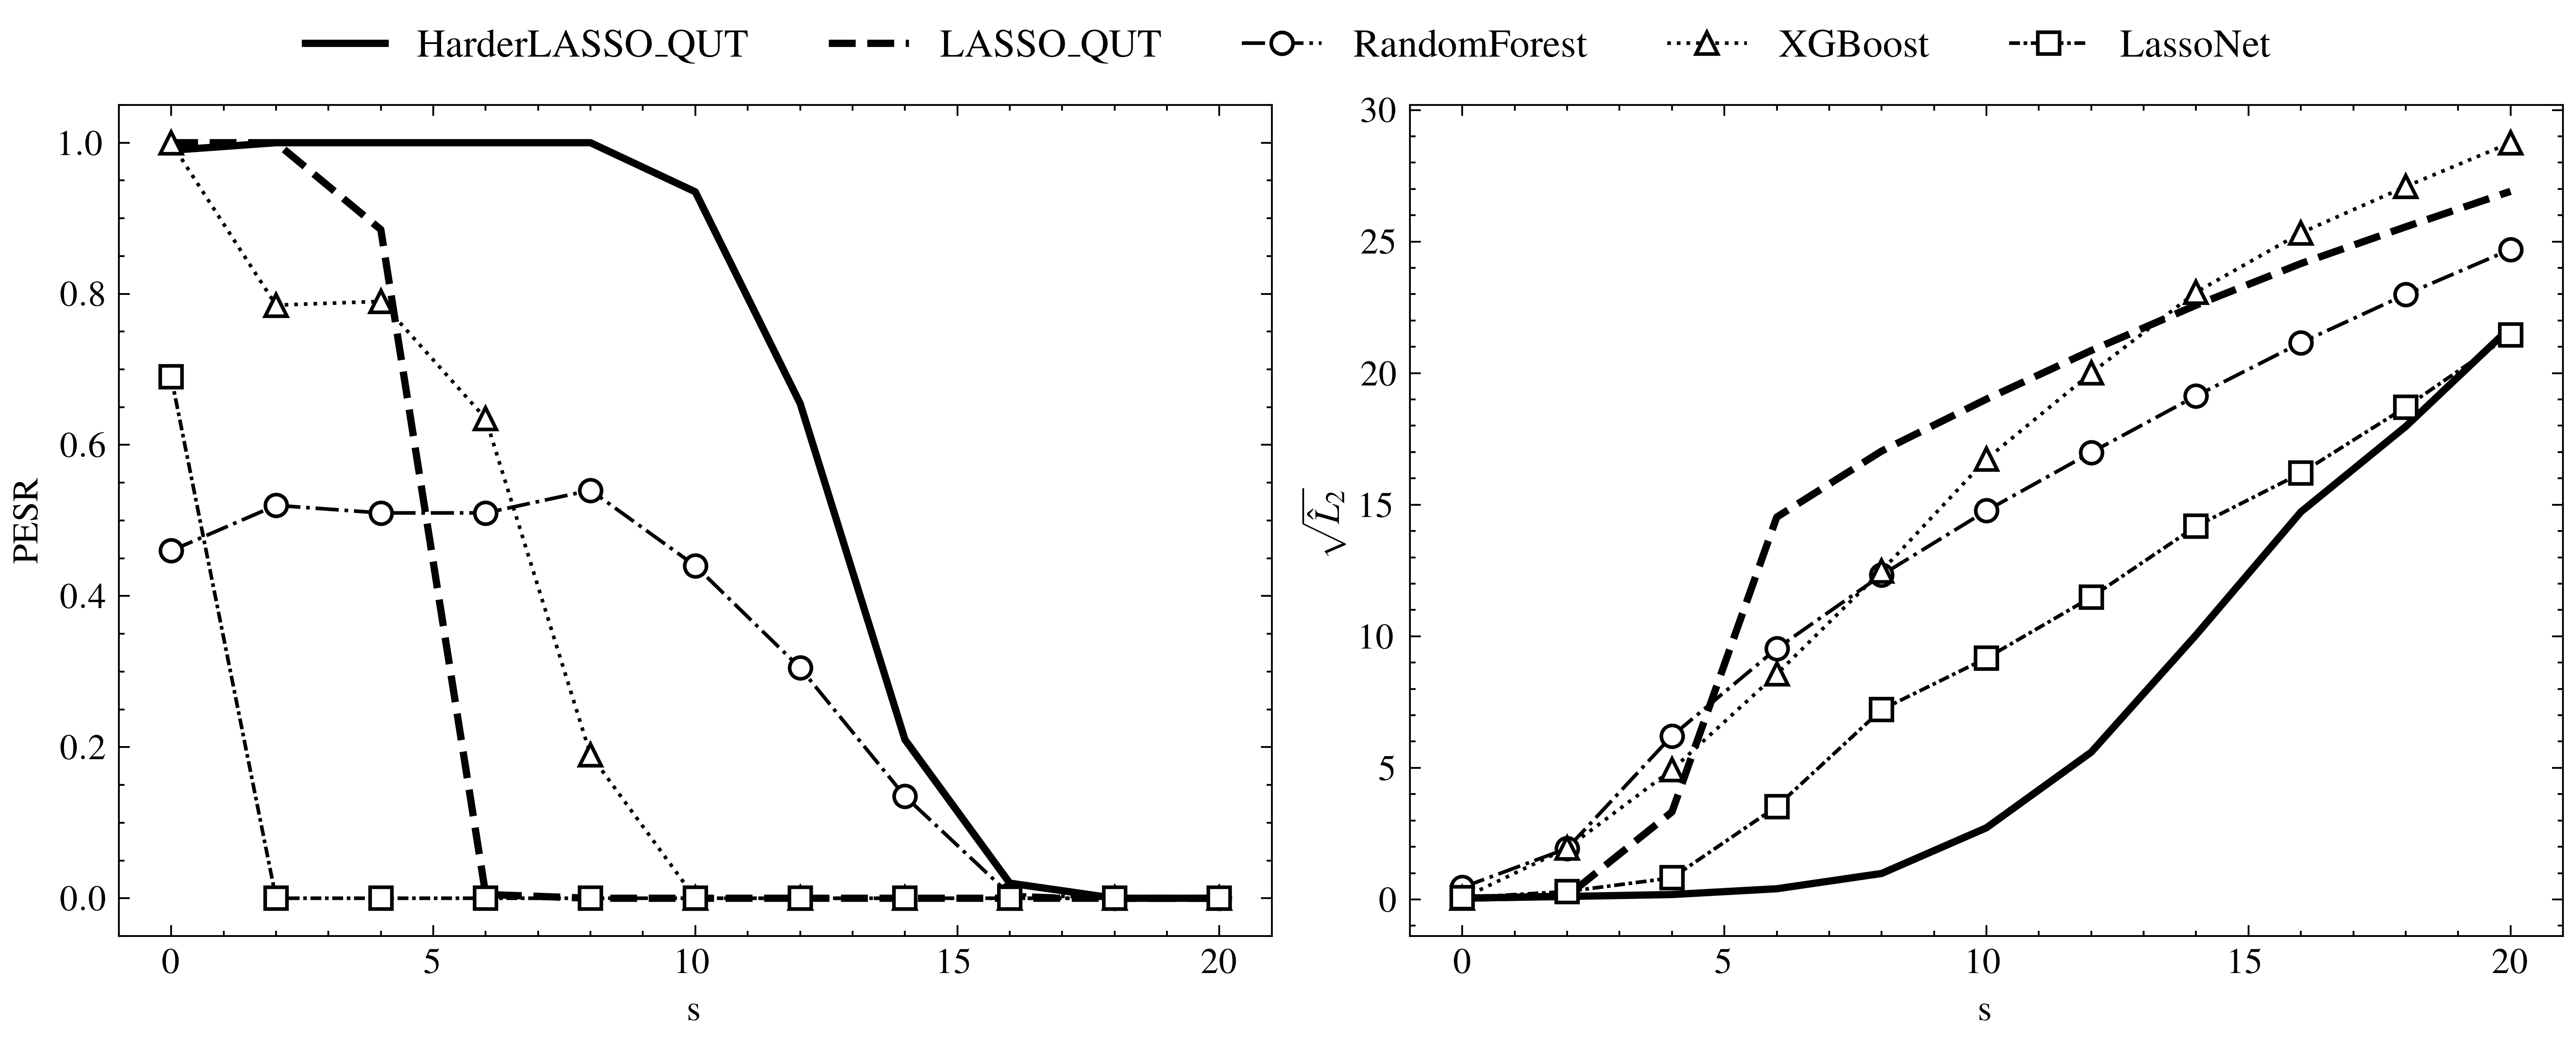

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

method_styles = {
    'LASSO_QUT': {'ls':         'dashed',          'marker': 'None', 'markevery': 1},
    'HarderLASSO_QUT': {'ls':         'solid',           'marker': 'None', 'markevery': 1},

    'RandomForest':       {'ls':         'dashdot',         'marker': 'o', 'markevery': 1},
    'LassoNet':         {'ls':         (0, (3, 1, 1, 1)), 'marker': 's', 'markevery': 1},
    'XGBoost':      {'ls':         'dotted',          'marker': '^', 'markevery': 1},
}

# Define plots
metrics = {
    'pesr': {'ax': axes[0], 'label': 'PESR', 'yscale': 'linear'},
    'mse':  {'ax': axes[1], 'label':  r'$\sqrt{\hat{L}_2}$',  'yscale': 'linear'}
}

for metric_name, info in metrics.items():
    ax = info['ax']
    for method in METHODS:
        data = summary_stats[summary_stats['method'] == method]
        style = method_styles[method]

        lw = 2 if 'QUT' in method else 1.0

        plotf = ax.plot
        plotf(
            data['s_value'], data[metric_name],
            color='black',
            linestyle=style['ls'],
            marker=style['marker'],
            markersize=6,
            linewidth=lw,
            markerfacecolor='white',
            markeredgewidth=1,
            markevery=style['markevery'],
            label=method
        )

    # Axis labels & scaling
    ax.set_xlabel('s', fontsize=10)
    ax.set_ylabel(info['label'], fontsize=10)
    if info['label'] == 'PESR':
        ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(np.arange(0, 21, 5))
    ax.tick_params(axis='both', which='major', labelsize=10)

handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend at the top, centered.
# ncol sets how many columns the legend entries span.
fig.legend(
    handles, labels,
    fontsize=11,
    loc='upper center',
    ncol=len(METHODS),
    bbox_to_anchor=(0.5, 1.02)
)

# Adjust layout so subplots don't overlap the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('nonlinear_results1.pdf', dpi=500)
plt.show()

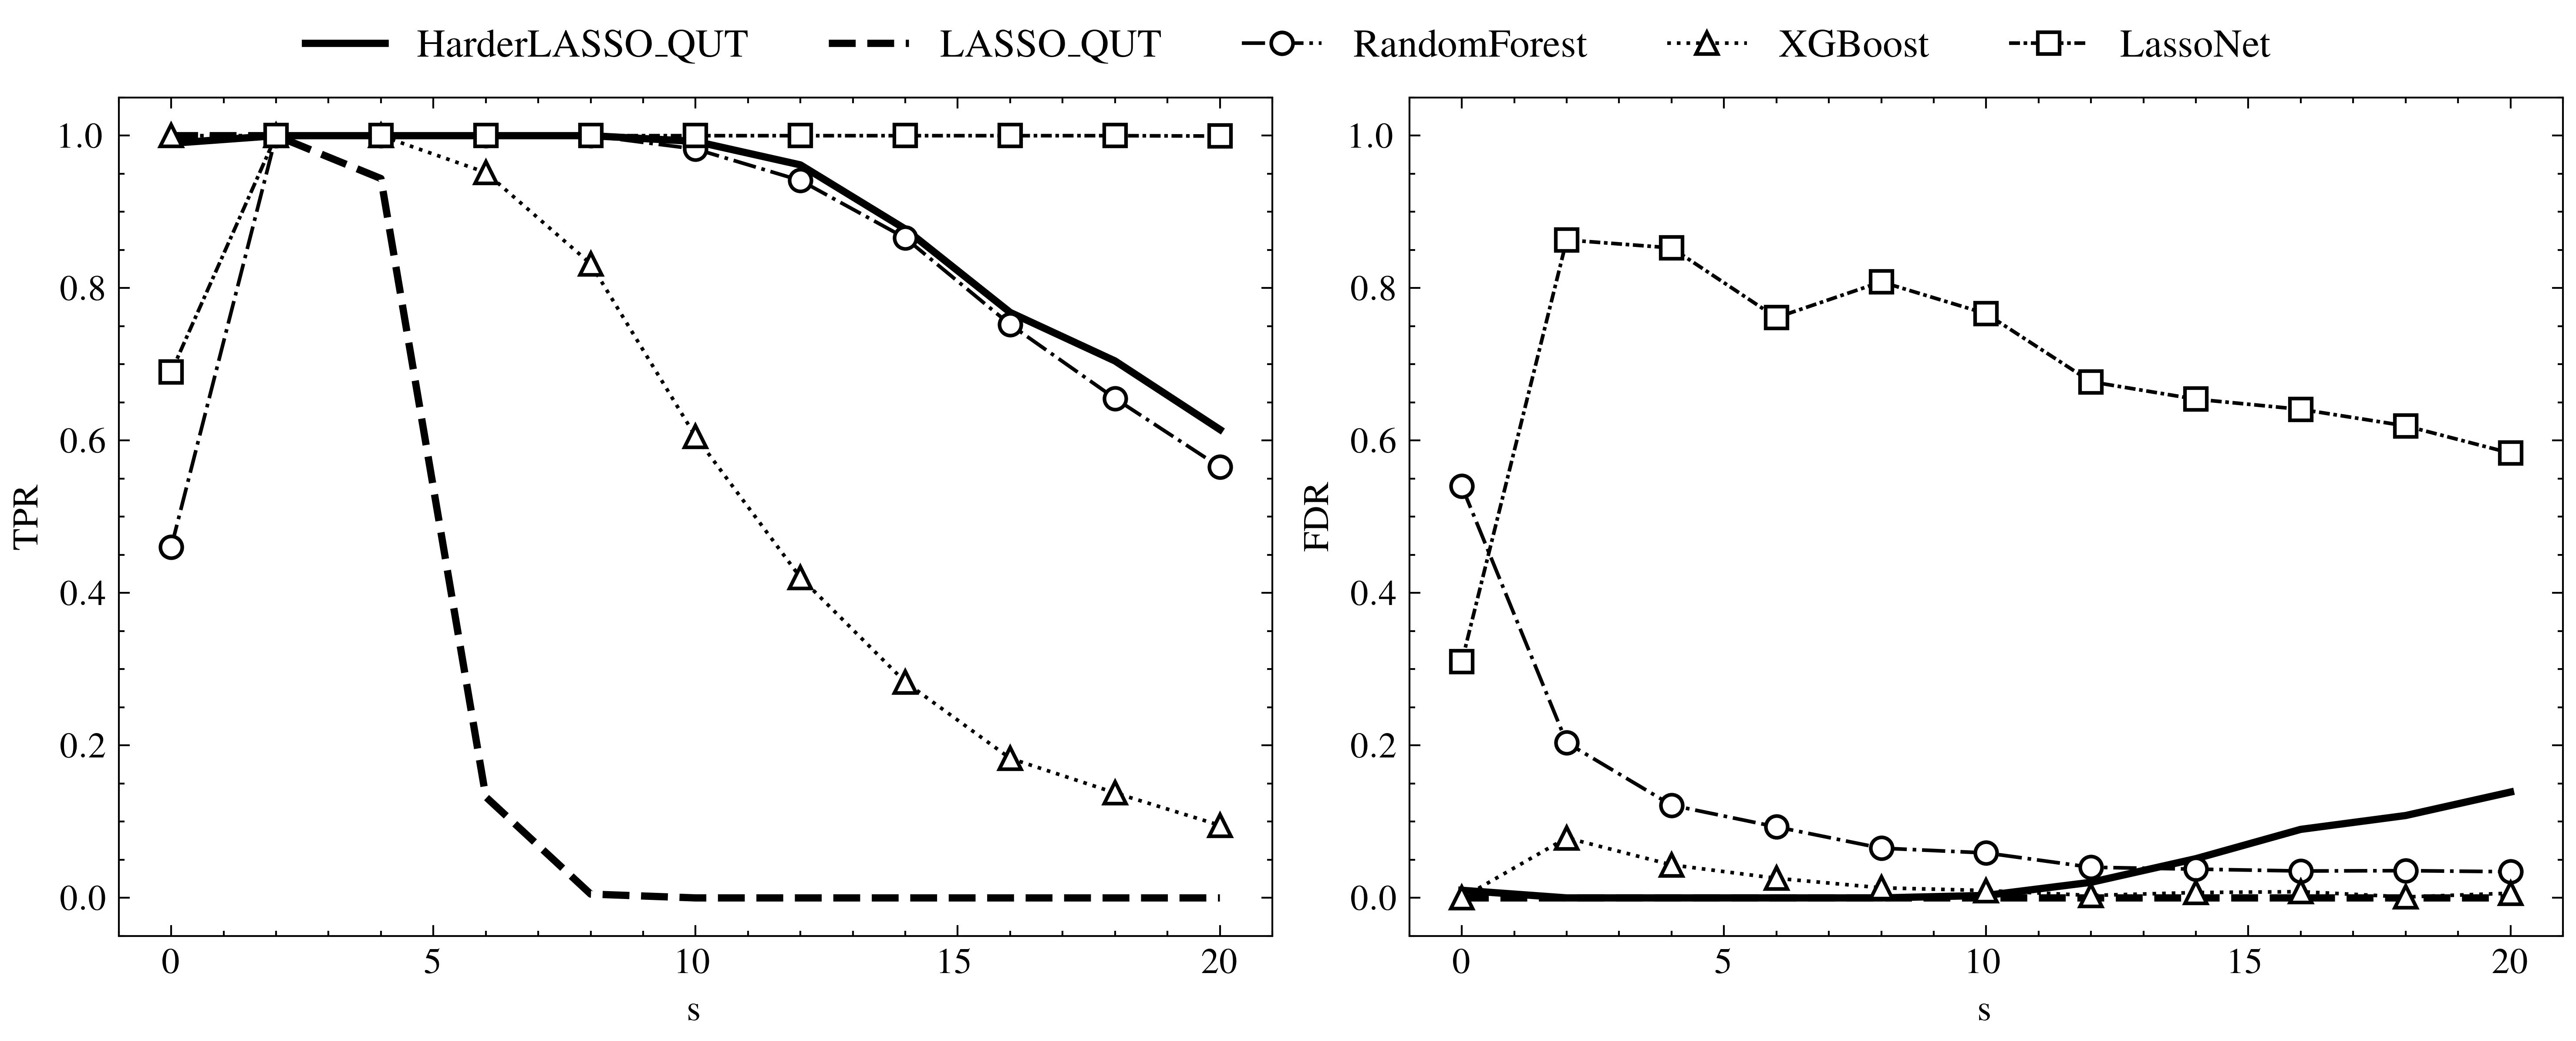

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Define plots
metrics = {
    'tpr':  {'ax': axes[0], 'label': 'TPR',  'yscale': 'linear'},
    'fdr':  {'ax': axes[1], 'label': 'FDR',  'yscale': 'linear'}
}

for metric_name, info in metrics.items():
    ax = info['ax']
    for method in METHODS:
        data = summary_stats[summary_stats['method'] == method]
        style = method_styles[method]

        lw = 2 if 'QUT' in method else 1.0

        plotf = ax.plot #if info['yscale']=='linear' else ax.semilogy
        plotf(
            data['s_value'], data[metric_name],
            color='black',
            linestyle=style['ls'],
            marker=style['marker'],
            markersize=6,
            linewidth=lw,
            markerfacecolor='white',
            markeredgewidth=1,
            markevery=style['markevery'],
            label=method
        )

    # Axis labels & scaling
    ax.set_xlabel('s', fontsize=10)
    ax.set_ylabel(info['label'], fontsize=10)
    ax.set_ylim(-0.05, 1.05)
    #ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_xticks(np.arange(0, 21, 5))
    ax.tick_params(axis='both', which='major', labelsize=10)

handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend at the top, centered.
# ncol sets how many columns the legend entries span.
fig.legend(
    handles, labels,
    fontsize=11,
    loc='upper center',
    ncol=len(METHODS),
    bbox_to_anchor=(0.5, 1.02)
)

# Adjust layout so subplots don't overlap the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('nonlinear_results2.pdf', dpi=500)
plt.show()